In [44]:
from collections import deque
from enum import Enum
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mesa import Model, Agent

In [45]:
class Move(Enum):
    COOPERATE = 1
    DEFECT = 2


class AxelrodAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.points = 0

    def step(self):
        """
        the move and any logic for deciding
        on the move goes here

        Returns
        -------
        Move.COOPERATE or Move.DEFECT

        """
        raise NotImplemetedError

    def receive_payoff(self, payoff, my_move, opponent_move):
        """

        Parameters
        ----------
        payoff : int
        my_move : {Move.COOPERATE, Move.DEFECT}
        opponents_move : {Move.COOPERATE, Move.DEFECT}

        """
        self.points += payoff
        
    def reset(self):
        """
        called after playing N iterations against
        another player
        """
        raise NotImplementedError
        

class TitForTat(AxelrodAgent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.opponent_last_move = Move.COOPERATE
    
    def step(self):
        return self.opponent_last_move
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move
        
    def reset(self):
        self.opponent_last_move = Move.COOPERATE


class ContriteTitForTat(AxelrodAgent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)
    
    def step(self):
        if (self.opponent_last_two_moves[0] == Move.DEFECT) and\
           (self.opponent_last_two_moves[1] == Move.DEFECT):
            return Move.DEFECT
        else:
            return Move.COOPERATE
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_two_moves.append(opponent_move)
        
    def reset(self):
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)        

        
class Defector(AxelrodAgent):
    
    def step(self):
        return Move.DEFECT
    
    def reset(self):
        pass

        
class Cooperator(AxelrodAgent):
    
    def step(self):
        return Move.COOPERATE
    
    def reset(self):
        pass
    
class GrimTrigger(AxelrodAgent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id,model)
        self.opponent_last_move = deque([Move.COOPERATE], maxlen = 1)
        self.betrayed = False
        
    def step(self):
        if self.betrayed:
            return Move.DEFECT
        else:
            return Move.COOPERATE
        
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        if opponent_move == Move.DEFECT:
            self.betrayed = True
            
    def reset(self):
        self.betrayed = False
        
        
class Pavlov(AxelrodAgent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.my_last_move = Move.COOPERATE
        self.opponent_last_move = Move.COOPERATE
    
    def step(self):
        if self.my_last_move == self.opponent_last_move:
            my_move = self.my_last_move
        else:
            my_move = self.opponent_last_move
            
        return my_move
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move
        self.my_last_move = my_move
    
    def reset(self):
        self.my_last_move = Move.COOPERATE
        self.my_opponent_last_move = Move.COOPERATE

class AxelrodModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, seed=None, noise_level=0.01):
        super().__init__(seed=seed)
        self.noise_level = noise_level
        self.num_iterations = N
        self.agents = []
        self.payoff_matrix = {}
        
        self.payoff_matrix[(Move.COOPERATE, Move.COOPERATE)] = (2, 2)
        self.payoff_matrix[(Move.COOPERATE, Move.DEFECT)] = (0, 3)
        self.payoff_matrix[(Move.DEFECT, Move.COOPERATE)] = (3, 0)
        self.payoff_matrix[(Move.DEFECT, Move.DEFECT)] = (1, 1)
        
        # Create agents
        for i, agent_class in enumerate(AxelrodAgent.__subclasses__()):
            a = agent_class(i, self)
            self.agents.append(a)

    def step(self):
        """Advance the model by one step."""
        for agent_a, agent_b in combinations(self.agents, 2):
            for _ in range(self.num_iterations):
                move_a = agent_a.step()
                move_b = agent_b.step()
                
                if self.random.random() < self.noise_level:
                    if move_a == Move.COOPERATE:
                        move_a = Move.DEFECT
                    else:
                        move_a = Move.COOPERATE
                if self.random.random() < self.noise_level:
                    if move_b == Move.COOPERATE:
                        move_b = Move.DEFECT
                    else:
                        move_b = Move.COOPERATE
                        
                payoff_a, payoff_b = self.payoff_matrix[(move_a, move_b)]
                
                agent_a.receive_payoff(payoff_a, move_a, move_b)
                agent_b.receive_payoff(payoff_b, move_b, move_a)
            agent_a.reset()
            agent_b.reset()

In [46]:
model = AxelrodModel(200)
model.step()

scores = [(agent.__class__.__name__, agent.points) for agent in model.agents]
scores.sort(key=lambda x: x[1], reverse=True)
for entry in scores:
    print(entry)

('ContriteTitForTat', 1647)
('GrimTrigger', 1523)
('Pavlov', 1523)
('TitForTat', 1491)
('Defector', 1419)
('Cooperator', 1236)


In [51]:
from collections import Counter, defaultdict

class EvolutionaryAxelrodModel(Model):
    """A model with some number of agents."""
    def __init__(self, num_agents, N, seed=None):
        super().__init__(seed=seed)
        
        self.num_iterations = N
        self.agents = []
        self.payoff_matrix = {}
        self.population_size = len(AxelrodAgent.__subclasses__())*num_agents
        
        self.payoff_matrix[(Move.COOPERATE, Move.COOPERATE)] = (2, 2)
        self.payoff_matrix[(Move.COOPERATE, Move.DEFECT)] = (0, 3)
        self.payoff_matrix[(Move.DEFECT, Move.COOPERATE)] = (3, 0)
        self.payoff_matrix[(Move.DEFECT, Move.DEFECT)] = (1, 1)        
        
        strategies = AxelrodAgent.__subclasses__()
        num_strategies = len(strategies)
        proportions = {agent_class:1/num_strategies for agent_class in strategies}

        self.num_iterations = N
        self.scores = defaultdict(list)
        for agent_class in strategies:
            self.scores[agent_class].append(proportions[agent_class])        
        
        self.initial_population_size = num_agents * num_strategies
        self.agent_id = 0
        self.build_population(proportions)
        
    def step(self):
        """Advance the model by one step."""
        for agent_a, agent_b in combinations(self.agents, 2):
            for _ in range(self.num_iterations):
                move_a = agent_a.step()
                move_b = agent_b.step()
                
                payoff_a, payoff_b = self.payoff_matrix[(move_a, move_b)]
                
                agent_a.receive_payoff(payoff_a, move_a, move_b)
                agent_b.receive_payoff(payoff_b, move_b, move_a)
            agent_a.reset()
            agent_b.reset()
        
        # calculate scores per class of agents
        scores = Counter()
        for agent in self.agents:
            scores[agent.__class__] += agent.points
        
        # normalize scores on unit interval
        total = sum(scores.values())
        
        proportions = {k: v/total for k, v in scores.items()}
            
        # keep track of proportions over the generations
        for agent_class in AxelrodAgent.__subclasses__():
            self.scores[agent_class].append(proportions[agent_class])
        
        self.build_population(proportions)
        
    def build_population(self, proportions):
        """build the new population

        Parameters
        ----------
        proportions : dict
                      key is agent class, value is float

        """
           
        # build new population
        population = []
        
        for agent_class, proportion in proportions.items():
            num_agents = round(self.initial_population_size*proportion)
            
            for i in range(num_agents):
                self.agent_id += 1
                a = agent_class(self.agent_id, self)
                population.append(a)
                
               
        # create a number of agents proportional to the normalized scores
        # ensure that the total size of the population (num_agents * num_strategies) 
        # stays as close to the initial population size
        ...
        
        
        self.agents = population

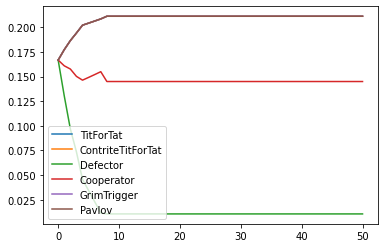

In [53]:
model = EvolutionaryAxelrodModel(10, 200)

for _ in range(50):
    model.step()

# visualizing results using matplotlib
fig, ax = plt.subplots()
for k, v in model.scores.items():
    ax.plot(v, label=k.__name__)
ax.legend()
plt.show()

In [36]:
from collections import Counter, defaultdict

class NoisyEvolutionaryAxelrodModel(EvolutionaryAxelrodModel):
    
    def __init__(self, num_agents, N, noise_level=0.01, seed=None):
        super().__init__(num_agents, N, seed=seed)
        self.noise_level = noise_level
        
    
    def step(self):
        """Advance the model by one step."""
        for agent_a, agent_b in combinations(self.agents, 2):
            for _ in range(self.num_iterations):
                move_a = agent_a.step()
                move_b = agent_b.step()
                
                #insert noise in movement
                ...

                payoff_a, payoff_b = self.payoff_matrix[(move_a, move_b)]
                
                agent_a.receive_payoff(payoff_a, move_a, move_b)
                agent_b.receive_payoff(payoff_b, move_b, move_a)
            agent_a.reset()
            agent_b.reset()
            
        # calculate scores per class of agents
        scores = Counter()
        for agent in self.agents:
            scores[agent.__class__] += agent.points
        
        # normalize scores on unit interval
        total = sum(scores.values())
        proportions = {k:v/total for k,v in scores.items()}
        
        # keep track of proportions over the generations
        for agent_class in AxelrodAgent.__subclasses__():
            self.scores[agent_class].append(proportions[agent_class])
        
        self.build_population(proportions)

NameError: name 'self' is not defined